# Cloud Diffusion: Whitening Models


In [1]:
# Import packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import linregress
import time
import torchvision.utils

import importlib
import data
import helpers
import unet
import cloud_diffusion as cd

import RealFFT
from RealFFT import fft
from RealFFT import ifft
from RealFFT import rfft
from RealFFT import irfft

from IPython.display import clear_output

import copy

In [292]:
# Uncomment and run these when making changes to .py files that require reloading modules
# Can also restart kernel, but this allows for reloading without running everything again
importlib.reload(data)
importlib.reload(helpers)
importlib.reload(unet)
importlib.reload(cd)

from helpers import fft
from helpers import ifft

## Datasets and Dataloaders
The dataset is pulled from the STL10 unlabeled dataset consisting of 10,000 images in natural settings. Following the procedure in [Scale Invariance](./Scale_Invariance.ipynb, we first filter the dataset and dataloaders to remove images that contain light or dark bars on the image edges. The images are minimally processed applying only a grayscale transformation for a single color channel.

In [8]:
device = helpers.getDevice()
print(device)

mps


In [3]:
batch_size = 64
color_channels = 1
N = 96
num_workers = 4

In [4]:
clean_dataset, dirty_dataset = data.get_datasets(batch_size=batch_size, grayscale=True)
dataloader = torch.utils.data.DataLoader(clean_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

37157/100000 images (37.157%), moved to dirty dataset.
Clean list clipped to 62784 images so it is divisible by batch_size=64.


### Calculating the mean and standard deviation
We calculate the pixelwise mean and std of the clean image set, which we will use to normalize the images on a pixel-by-pixel basis. 
As discussed in [Scale Invariance](./Scale_Invariance.ipynb) the probability density function of the Fourier transformed image set can be reasonably approximated by a complex multivariate normal distribution with variance tensors
$$
{\Sigma^{ij}}_{kl} = \frac{A^2}{r^{2\Delta}} \delta^i_k\delta^j_l \quad \quad {C^{ij}}_{kl}=0 
$$
where the constant $\Delta$ is measured to be
$$
\begin{eqnarray}
\Delta &=& 1.4999373536194076\,.
\end{eqnarray}
$$
We determine $A$ by requiring that the noise in position space is normalized to have standard deviation equal to $1$.

In [6]:
Delta = 1.4999373536194076
A = 0.10375943093487151

## Uncomment below if we need to recalculate A
# noise_generator_96 = helpers.NoiseGenerator(N=96)
# Delta = 1.4999373536194076
# A = noise_generator_96.get_normalizing_A(Delta=Delta, n_batches=10000, device="mps")

The position space mean and standard deviation are used to normalize the images to have mean $0$ and standard deviation $1$. Note that we will employ a pixel-by-pixel normalization – the mean and std of each pixel of the image set is calculated and used to normalize that pixel. This is justified because the mean and std are nearly homogenous in position space as seen in [Scale Invariance](./Scale_Invariance.ipynb). 

In [7]:
mu, std = helpers.get_mu_and_std(clean_dataset)

In [10]:
noise_generator_96 = helpers.NoiseGenerator(N=N, device="mps")

In [293]:
torch.mps.empty_cache()
mu_whitened, std_whitened = helpers.get_whitened_mu_and_std(dataloader=dataloader, 
                                                    mu=mu, 
                                                    std=std, 
                                                    Delta=Delta,  
                                                    noise_generator=noise_generator_96,
                                                    eps=.001,
                                                    batch_size=batch_size,
                                                    N=N,
                                                    device=device)

Calculating STD: 900/981


## Visualizing Whitened Images

tensor(0.0003)
tensor(-10.0702)
tensor(11.0562)
tensor(1.0795)
tensor(0.4214)
tensor(-6.1849)
tensor(9.5939)
tensor(2.5311)


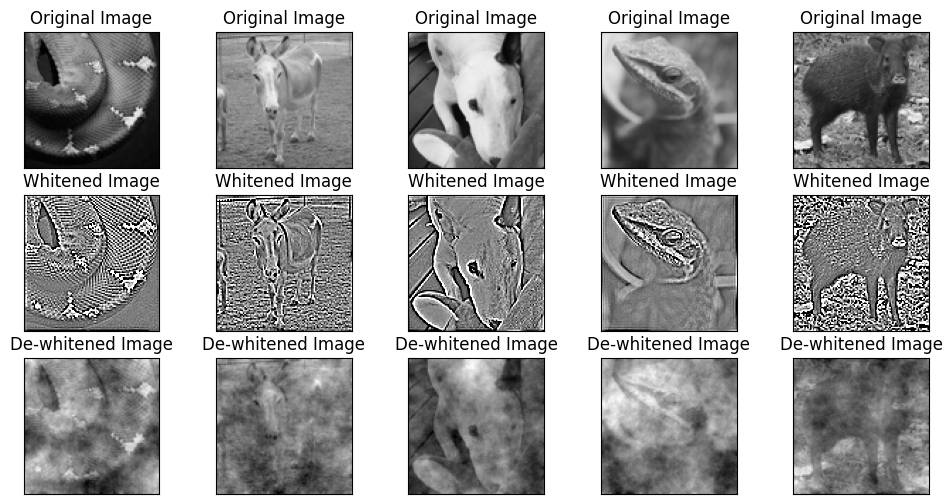

In [364]:
eps=.001
x = torch.zeros(64,1,96,96)
for i in range(64):
    randint = np.random.randint(len(clean_dataset))
    x[i,...] = clean_dataset[randint][0]

y = helpers.whiten(x, 
                   mu=mu, 
                   std=std, 
                   Delta=Delta, 
                   eps=eps, 
                   noise_generator=noise_generator_96, 
                   mu_whitened=mu_whitened, 
                   std_whitened=std_whitened)

z = helpers.dewhiten(y, 
                   mu=mu, 
                   std=std, 
                   Delta=Delta, 
                   eps=eps, 
                   noise_generator=noise_generator_96, 
                   mu_whitened=mu_whitened, 
                   std_whitened=std_whitened)

print(y.mean())
print(y.min())
print(y.max())
print(y.std())

a = .4
noise = torch.randn_like(y)
Y = np.cos(a*np.pi/2)*y + np.sin(a*np.pi/2)*torch.randn_like(y)

Z = helpers.dewhiten(Y, 
                   mu=mu, 
                   std=std, 
                   Delta=Delta, 
                   eps=eps, 
                   noise_generator=noise_generator_96, 
                   mu_whitened=mu_whitened, 
                   std_whitened=std_whitened)


print(Z.mean())
print(Z.min())
print(Z.max())
print(Z.std())


fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(12, 6))
for i in range(5):
    axs[0][i].set_title("Original Image")
    axs[0][i].imshow(x[i,0,...], vmin=0, vmax=1, cmap="gray")
    axs[1][i].set_title("Whitened Image")
    axs[1][i].imshow(y[i,0,...], vmin=-1, vmax=1, cmap="gray")
    axs[2][i].set_title("De-whitened Image")
    axs[2][i].imshow(Z[i,0,...], cmap="gray")
    
plt.setp(axs, xticks=[], yticks=[])
plt.show()

### The Model Variables
Here we define a ModelVariables class to serve as a container for our adjustable variables. 

In [162]:
mv = cd.ModelVariables()

In [341]:
# Model Type ("white", "cloud", "whitened")
mv.model_type = "whitening"

# DataLoader
mv.dataloader = dataloader

# image norm, std, A, Delta
mv.mu=mu
mv.std=std
mv.A=A
mv.Delta=Delta

# batch size, color channels, image size (NxN)
mv.batch_size=batch_size
mv.color_channels=color_channels
mv.N=N

# Eigenvalues and eigenvectors for color models. Should be of the form (L,V).
mv.eigs=None #(L,V)

# Set the regulator for the whitening transformation (usually small like .001)
mv.whitening_epsilon=.001

# Scale factor for channels in UNet (default: 32 with 2M parameters)
# Note: model parameters explode for large values. 42 gives ~3.5M params.
mv.scale_factor=42

# Device (note: can only use cpu on mac)
mv.device=device

# Number of epochs
mv.n_epochs=5

# Diffusion time steps
mv.T=1000

# data type
mv.dtype=torch.float

# Color map for visualization
mv.cmap = "gray"

# normalization mode for fft (default should be "ortho" for symmetric normalization)
mv.fft_norm="ortho"

# Activation function
# mv.activation=torch.nn.ReLU()
mv.activation=torch.nn.LeakyReLU()
# mv.activation = torch.nn.SiLU()

# Work in Real Fourier Space? If so, everything is converted using rfft and output is in real Fourier Space.
mv.real_fourier_space = False

# Loss Function
#mv.loss_function = cd.KL_Loss_Color(Delta=mv.Delta, dist=noise_generator_96.dist, eigs=mv.eigs, device=mv.device, epsilon=0.01)
# mv.loss_function = cd.Mahalanobis_Loss(Delta=mv.Delta, 
#                                        dist=noise_generator_96.dist,
#                                        real_fourier_space=mv.real_fourier_space,
#                                        device=mv.device, 
#                                        epsilon=0.005)
mv.loss_function = cd.L2Loss(device=device)

# Diffusion schedule (cosine diffusion schedule is standard)
mv.diffusion_schedule=cd.offset_cosine_diffusion_schedule

# AdamW optimizer parameters
mv.max_learning_rate=.001
mv.min_learning_rate=.0001
mv.betas=(0.9, 0.999)
mv.weight_decay=0.01

# Cap number of training batches (set to None for no cap)
mv.n_train_batches = None

In [359]:
mv2 = copy.copy(mv)
mv2.real_fourier_space = True

mv2.loss_function = cd.Mahalanobis_Loss(Delta=mv.Delta, 
                                       dist=noise_generator_96.dist,
                                       real_fourier_space=True,
                                       device=mv.device, 
                                       epsilon=0.001)

tensor(0.0013, device='mps:0')
tensor(1.7456, device='mps:0')


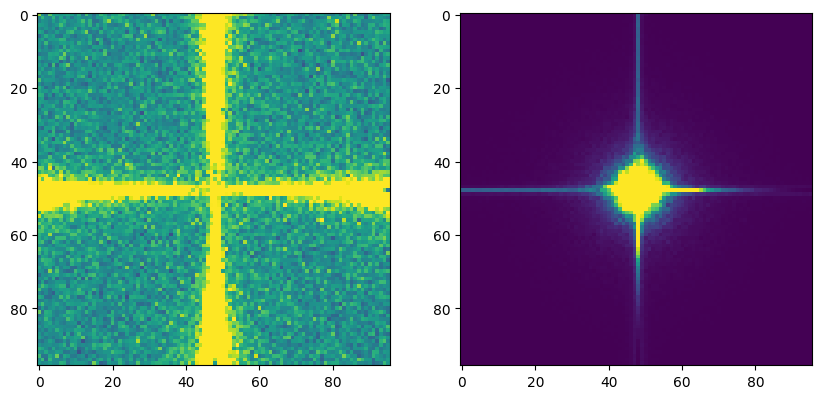

In [340]:
eps = .005

noise1 = rfft(noise_generator_96.generate_monochrome_noise(Delta=Delta, A=A, batch_size=64, device=mv.device)[0].real)
noise2 = rfft(noise_generator_96.generate_monochrome_noise(Delta=Delta, A=A, batch_size=64, device=mv.device)[0].real)

X = noise1-noise2

k2D = (noise_generator_96.dist.squeeze()+eps)**(2*mv.Delta)

loss1 = torch.einsum("bcij,ij,bcij->ij", X, k2D, X)/batch_size #Maha Squared Distance
loss2 = torch.einsum("bcij,bcij->ij", X, X)/batch_size #L2 Norm

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axs[0].imshow(loss1.to("cpu"), vmin=0, vmax=loss1.mean())
axs[1].imshow(loss2.to("cpu"), vmin=0, vmax=loss2.mean())
print(loss1[96//2, 96//2])
print(loss2.mean())

### The Model
Finally we define the Cloud Diffusion Model

In [342]:
real_cloud_diffusion_model = cd.RealCloudDiffusionModel(mv=mv)

RealCloudDiffusionModel Parameters = 3359539


Epoch: 5/5 | Batch: 980/981 | Loss: 0.9886682033538818
Total Time (minutes): 117.43877209822337 | Time per batch: 1.4934961795806885


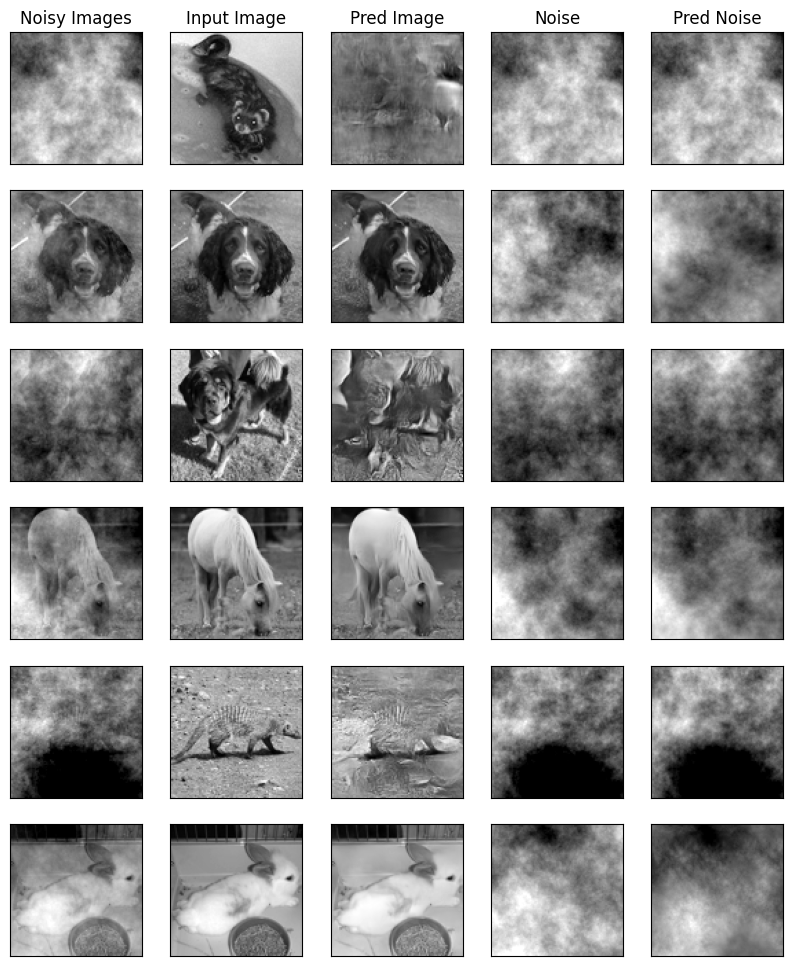

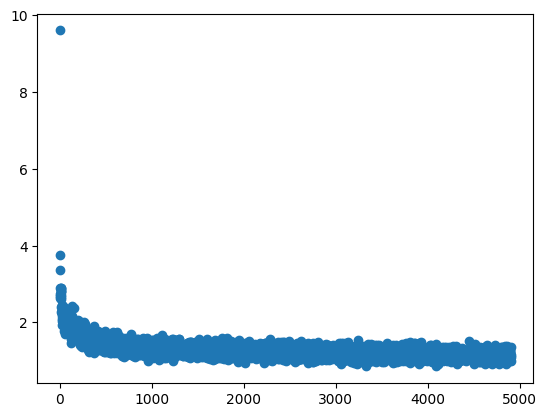

In [344]:
real_cloud_diffusion_model.mv = mv
losses = real_cloud_diffusion_model.train_it()

In [366]:
torch.mps.empty_cache()

In [367]:
rfft_model = cd.RealCloudDiffusionModel(mv=mv2)

RealCloudDiffusionModel Parameters = 3359539


In [368]:
losses = rfft_model.train_it()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ac.randono/anaconda3/envs/experiments_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/km/ccvdzxy17_9bl9gpw7yjs5xm0000gq/T/ipykernel_2236/1607906220.py", line 1, in <module>
    losses = rfft_model.train_it()
             ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ac.randono/Python Projects/AI Experiments/Scale Invariance/cloud_diffusion.py", line 442, in train_it
    self.optimizer.step()
  File "/Users/ac.randono/anaconda3/envs/experiments_env/lib/python3.11/site-packages/torch/optim/optimizer.py", line 493, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ac.randono/anaconda3/envs/experiments_env/lib/python3.11/site-packages/torch/optim/optimizer.py", line 91, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ac.randono/anaconda3/e

### Save the Model

In [ ]:
def save_checkpoint(model, filename, model_variables):
    
    filepath = f"checkpoints/{filename}.tar"
    
    torch.save({
                'model_variables': model_variables,
                'model_state_dict': model.network.state_dict(),
                'optimizer_state_dict': model.optimizer.state_dict(),
                'losses': losses
                }, filepath)
    print(f"Saved model to {filepath}")

In [ ]:
save_checkpoint(real_cloud_diffusion_model, "color_model_3a", mv)

### Generating Images
We use the reverse diffusion process to generate image batches. Starting at $t=0$ we predict the image and the noise, then use these to generate the noisy image in the next time step. The "stochasticity" parameter is a number between 0 and 1. Setting it to 0 makes the model use just the predicted noise for the next time step. Setting it to 1 forces the model to generate new noise (white or cloud) for each time step and ignores the predicted noise. Non-zero values weight the predicted and stochastic noise respectively. 

For best images use 1000 diffusion steps. 

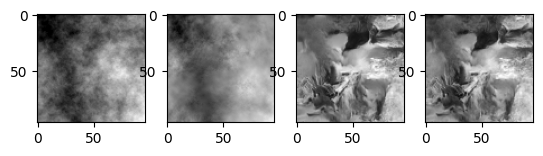

Step 1000/1000 | Time Elapsed Last 100 Steps = 28.2845618724823


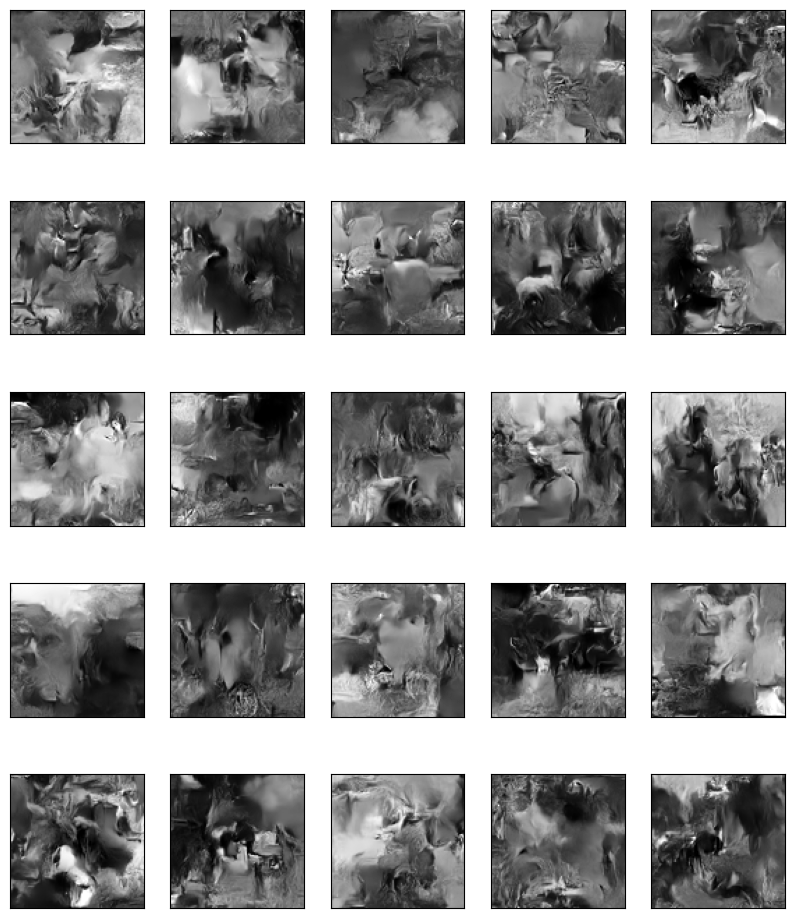

In [353]:
predicted_x0 = cd.real_reverse_diffusion(model=real_cloud_diffusion_model, 
                                         diffusion_steps=1000, 
                                         start_step=0,
                                         print_every=100,
                                         stochasticity=0,
                                        )

In [349]:
image_grids = []
normed_predicted_x0 = real_cloud_diffusion_model.denormalize(predicted_x0)
for i in range(7):
    mini_batch = normed_predicted_x0[9*i:9*(i+1)]
    grid = torchvision.utils.make_grid(mini_batch, nrow=3, padding=20, pad_value=.5)                  
    image_grids.append(grid)
        
for grid in range(len(image_grids)):
    torchvision.utils.save_image(image_grids[grid], f"Images/3M_Param_Model_2/images_{grid}.jpg")

### Frechet Inception Distance

To numerically quantify the quality of images for white and cloud noise we turn to the Frechet Inception Distance. We assume that the image set can be modelled by normal distributions and calculate the FID accordingly. For two multivariate normal distributions, the FID is given by:
$$
d_F\left(\mathcal{N}(\mu, \Sigma), \mathcal{N}(\mu', \Sigma')\right) = \left|\mu - \mu'\right|^{2} + \text{tr}\left(\Sigma +\Sigma' - 2 \left(\Sigma \Sigma'\right)^{\frac{1}{2}}\right)
$$

## Saving images for $\Sigma$ calculations
Here we generate 16 images batches for a total of 1024 images. These are saved for use in the calculation of $\Sigma$.

In [ ]:
checkpoint = torch.load("checkpoints/new_cloud_model_5.tar")
cloud_mv = checkpoint["model_variables"]
cloud_diffusion_model = cd.RealCloudDiffusionModel(cloud_mv)
cloud_diffusion_model.network.load_state_dict(checkpoint['model_state_dict'])
cloud_diffusion_model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
n=100
filename = "new_cloud_model_5"

t0 = time.time()
for i in range(n):
    filepath = f"Images/{filename}/generated_tensor_{i+1}.pt"

    predicted_x0 = cd.real_reverse_diffusion(model=cloud_diffusion_model)
    torch.save(predicted_x0, filepath)
    
    print(f"=========== Total Time Elapsed (minutes: {(time.time()-t0)/60} =============")
    print(f"Step {i+1}/{n} complete. File saved to {filepath}")

In [ ]:
a=2
b=.2
M = a*torch.ones(3,3)+b*torch.ones(3,3)
L,V = torch.linalg.eig(M)

print(L.real)
print(V.real)


In [144]:
z,Z = noise_generator_96.generate_monochrome_noise(Delta=Delta, A=A)
print(torch.std(z.real))

tensor(0.9688)


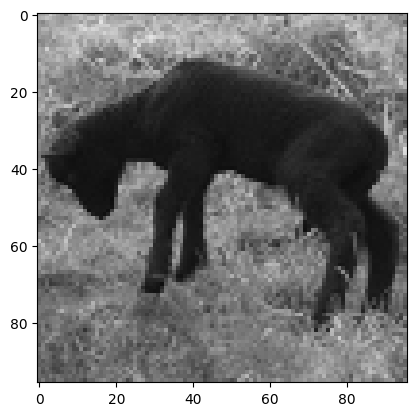

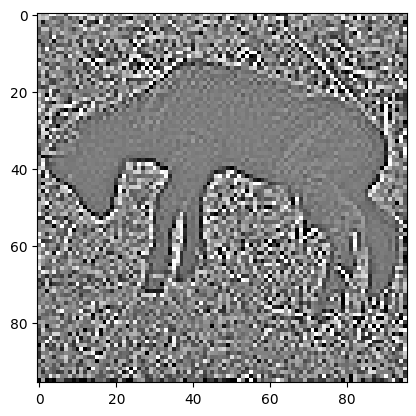

In [1338]:
randint = np.random.randint(len(clean_dataset))
ep=0.001
dD = (noise_generator_96.dist.to("cpu")+ep).squeeze()**(Delta)

x = clean_dataset[randint][0].squeeze()
F = rfft(x)

x2 = irfft(F*dD)

a=.03

plt.imshow(x, cmap="gray", vmin=0, vmax=1)
plt.show()

plt.imshow((x2), cmap="gray", vmin=-a, vmax=a)
plt.show()
        
# plt.imshow((f.imag*dD).abs(), cmap="gray", vmin=0, vmax=a)
# plt.show()



In [1347]:
data_iter = iter(dataloader)
MU = torch.zeros(96,96, device="mps")
ep=.001
dD = (noise_generator_96.dist.to("mps")+ep).squeeze()**(Delta)

for n in range(len(data_iter)):
    x = next(data_iter)[0].to("mps").squeeze()
    _MU = torch.mean(x,dim=0)
    MU = (MU*n + _MU)/(n+1)
    
    if n%100 == 0:
        print(f"{n}/{len(data_iter)} complete")
        clear_output(wait=True)

900/981 complete


In [1348]:
data_iter = iter(dataloader)
sig = torch.zeros(96,96,96,96, device="mps")

for n in range(len(data_iter)):
    x = next(data_iter)[0].to("mps").squeeze()
    X = irfft(rfft(x-MU)*dD)
    _sig = torch.einsum("bij,bkl->ijkl", X, X)/64
    sig = (sig*n + _sig)/(n+1)
    
    if n%100 == 0:
        print(f"{n}/{len(data_iter)} complete")
        clear_output(wait=True)

900/981 complete


(10,28)


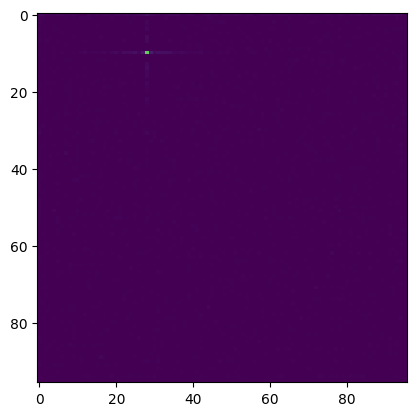

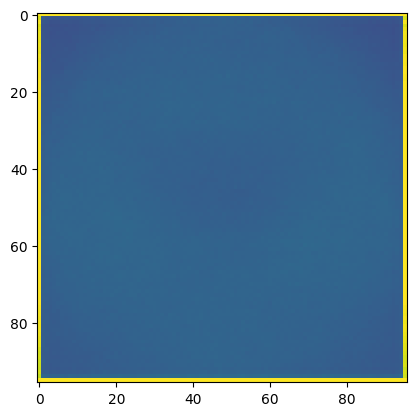

tensor(-1.6932e-05)
tensor(0.0002)
tensor(-1.8871e-10)
tensor(0.0001, device='mps:0')
tensor(0.0011, device='mps:0')
tensor(0.0002, device='mps:0')


In [1551]:
i = np.random.randint(96)
j = np.random.randint(96)

print(f"({i},{j})")
sij = sig.to("cpu")[:,:,i,j]
s_diag = torch.einsum("ijij->ij", sig)


# plt.imshow(MU.to("cpu"), vmin=-.1, vmax=.1)
# plt.show()

plt.imshow(sij, vmin=0, vmax=.0002)
plt.show()

plt.imshow(s_diag.to("cpu"), vmin=0, vmax=.0005)
plt.show()

print(sij.min())
print(sij.max())
print(sij.mean())

print("=======")

print(s_diag.min())
print(s_diag.max())
print(s_diag.mean())

In [1557]:
z = torch.zeros(64,1,96,96, device="mps")

In [1558]:
print(z.shape)

torch.Size([64, 1, 96, 96])


In [20]:
torch.mps.empty_cache()
mu_whitened, std_whitened = helpers.get_whitened_mu_and_std(dataloader=dataloader, 
                                                    mu=mu, 
                                                    std=std, 
                                                    Delta=Delta,  
                                                    noise_generator=noise_generator_96,
                                                    eps=.001,
                                                    batch_size=64,
                                                    N=96,
                                                    device="mps")

Calculating STD: 900/981


In [21]:
print(mu_whitened.shape)
print(std_whitened.shape)

torch.Size([96, 96])
torch.Size([96, 96])


In [216]:
print(clean_dataset[randint][0].shape)

torch.Size([1, 96, 96])


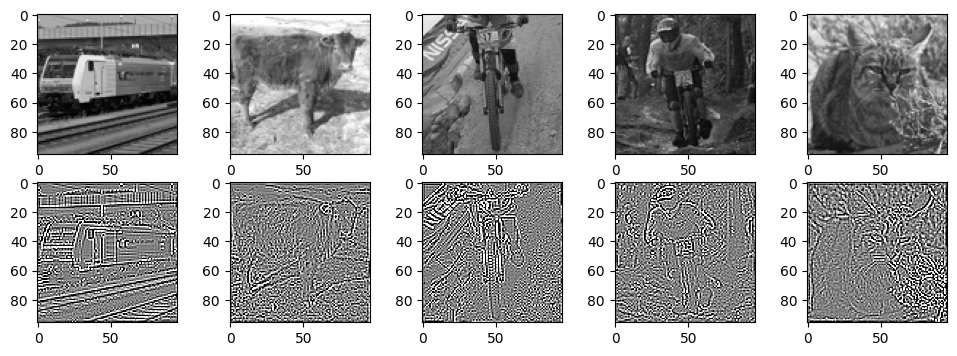

In [274]:
x = torch.zeros(64,1,96,96)
for i in range(64):
    randint = np.random.randint(len(clean_dataset))
    x[i,...] = clean_dataset[randint][0]


y = helpers.whiten(x, mu=mu, std=std, Delta=Delta, eps=.001, noise_generator=noise_generator_96, mu_whitened=mu_whitened, std_whitened=std_whitened)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))
for i in range(5):
    axs[0][i].imshow(x[i,0,...], vmin=0, vmax=1, cmap="gray")
    axs[1][i].imshow(y[i,0,...], vmin=-1, vmax=1, cmap="gray")
